# *TP1 - DEEP LEARNING*

<table style="width:100%">
  <tr>
    <td style="text-align:left"><strong>Préparé par :</strong> EL Warraqi Imane</td>
    <td style="text-align:right"><strong>Encadré par :</strong> Pr. HAMZA EL KHALFI </td>
  </tr>
</table>

# Partie 2 : _Implémentation avec Pytorch_

### 2.1 Forward et backward manuels
On va commencer par coder le réseau de neurones en utilisant simplement les opérations mathématiques de base et en transcrivant donc directement nos équations mathématiques. On utilisera les fonctions que l’on trouve dans le package `torch`.

#### Importations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt

#### Chargement des données

In [2]:
# charger les utilitaires de générations et visualisation des données
from utilitaires import *

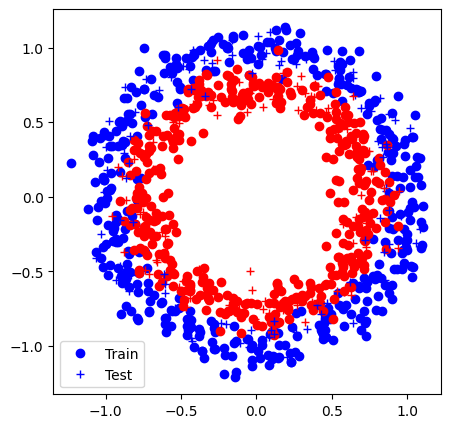

In [3]:
# préparer et visualiser le jeux de données
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
plot_data(data)

**1. Écrire la fonction `init_params(nx, nh, ny)` qui initialise les poids d'un réseau à partir des tailles nx, nh et ny et les sauvegarde dans un dictionnaire. Tous les poids seront initialisés selon une loi normale de moyenne 0 et d'écart-type 0.3.**


In [4]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: des nombres entiers
    out params: dictionnaire des paramètres
    """
    params = {}

    moyenne = 0
    ecart_type = 0.3
    
    #####################
    ## Votre code ici  ##
    #####################
    
    # remplir avec les paramètres Wh, Wy, bh, by
    params["Wh"] = ecart_type * torch.randn(nh, nx) + moyenne
    params["Wy"] = ecart_type * torch.randn(ny, nh) + moyenne
    params["bh"] = torch.zeros(nh, 1)
    params["by"] = torch.zeros(ny, 1)

    return params


**2. Écrire la fonction `forward(params, X)` qui calcule les étapes intermédiaires et la sortie du réseau à partir d’un batch d’entrée X et des poids stockés dans params et les stocke dans un dictionnaire. On retourne le dictionnaire des  ́etapes intermédiaires et la sortie Ŷ du réseau.**


In [6]:
def forward(params, X):
    """
    - In    :
        params  : dictionnaire des paramètres
        X       : batch d'entrée (n_batch, nx)
    - Out   :
        yhat    : sortie du réseau Ŷ (prédiction)
        outputs : dictionnaire des étapes intermédiaires et la sortie Ŷ du réseau.
    """
    
    outputs = {}
    #####################
    ## Votre code ici  ##
    ##################### 
    # remplir avec les paramètres X, htilde, h, ytilde, yhat
    # Stocker l'entrée
    outputs["X"] = X

    # Couche cachée 
    htilde = torch.mm(X, params["Wh"].t()) + params["bh"].t()
    outputs["htilde"] = htilde

    # Activation tanh
    h = torch.tanh(htilde)
    outputs["h"] = h

    # Couche de sortie 
    ytilde = torch.mm(h, params["Wy"].t()) + params["by"].t()
    outputs["ytilde"] = ytilde

    # SoftMax pour obtenir la prédiction
    exp_scores = torch.exp(ytilde)
    yhat = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    outputs["yhat"] = yhat

    return outputs["yhat"], outputs


**3. Écrire la fonction  `loss_accuracy(Yhat, Y)` qui calcule la fonction de coût et la précision (taux de
bonnes prédictions) à partir d’une matrice de sortie Ŷ (sortie de forward ) vis-à-vis d’une matrice de ground-truth Y de même taille, et retourne la loss L et la précision acc .**

In [7]:
def loss_accuracy(Yhat, Y):
    """
    Calcul de la loss cross-entropy et de la précision
    - Yhat : sortie du réseau (nbatch, ny)
    - Y : vérité terrain (one-hot, nbatch, ny)
    
    Retourne :
    - loss : cross-entropy moyenne
    - acc : précision (taux de bonnes prédictions)
    """
    # Cross-entropy
    loss = -torch.sum(Y * torch.log(Yhat)) / Y.shape[0]

    # Précision
    _, pred_inds = torch.max(Yhat, dim=1)
    _, true_inds = torch.max(Y, dim=1)
    acc = torch.mean((pred_inds == true_inds).float())
    
    return loss, acc


**4. Écrire la fonction `backward(params, outputs, Y)` qui calcule les gradients du loss par rapport
aux paramètres et les sauvegarde dans un dictionnaire.**


In [11]:
import torch

def backward(params, outputs, Y):
    """
    - In    :
        params  : dictionnaire des paramètres
        outputs : dictionnaire des sorties intermédiaires (X, htilde, h, ytilde, yhat)
        Y       : vérité terrain one-hot (batch_size, ny)
    - Out   :
        grads   : dictionnaire des gradients par rapport aux paramètres
    """
    
    bsize = Y.shape[0]  # taille du batch
    grads = {}

    # Gradient de la loss par rapport à ytilde (SoftMax + Cross-Entropy)
    dL_dytilde = (outputs["yhat"] - Y) / bsize  # r_y~

    # Gradients de la couche de sortie
    grads["Wy"] = torch.mm(dL_dytilde.t(), outputs["h"])  # ny x nh
    grads["by"] = torch.sum(dL_dytilde, dim=0, keepdim=True).t()  # ny x 1

    # Gradient de la couche cachée
    dh = torch.mm(dL_dytilde, params["Wy"])           # bsize x nh
    dh_tilde = dh * (1 - outputs["h"]**2)            # tanh'(htilde) -> bsize x nh

    # Gradients de la couche cachée
    grads["Wh"] = torch.mm(dh_tilde.t(), outputs["X"])          # nh x nx
    grads["bh"] = torch.sum(dh_tilde, dim=0, keepdim=True).t() # nh x 1

    return grads


**5. Écrire la fonction `sgd(params, grads, eta)` qui applique une descente de gradient stochastique par mini-batch et met à jour les paramètres du réseau à partir de leurs gradients et du pas d’apprentissage.**

In [12]:
def sgd(params, grads, eta):
    """
    Mise à jour des paramètres par SGD
    - params : dictionnaire des poids et biais
    - grads : dictionnaire des gradients
    - eta : learning rate
    """

    #####################
    ## Votre code ici  ##
    #####################
    # mettre à jour les params

    params["Wh"] -= eta * grads["Wh"]
    params["Wy"] -= eta * grads["Wy"]
    params["bh"] -= eta * grads["bh"]
    params["by"] -= eta * grads["by"]

    return params

**6. Application : Mettre en oeuvre l’algorithme global d’apprentissage en utilisant les fonctions précédentes.**



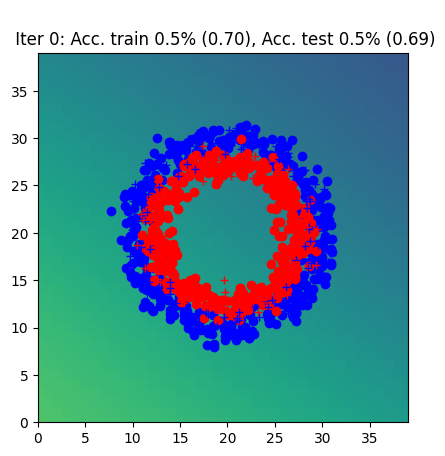

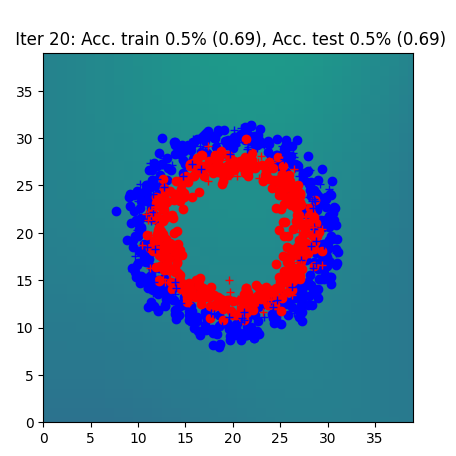

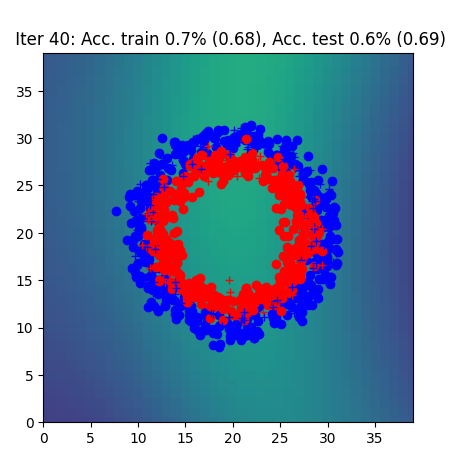

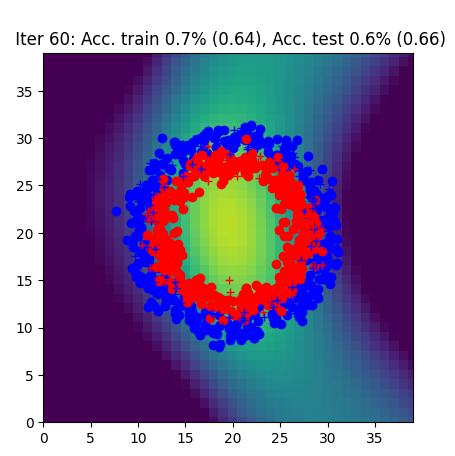

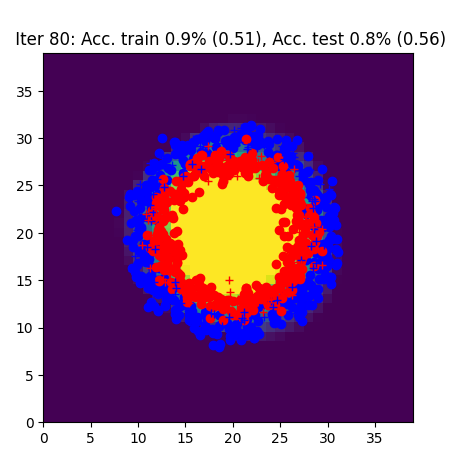

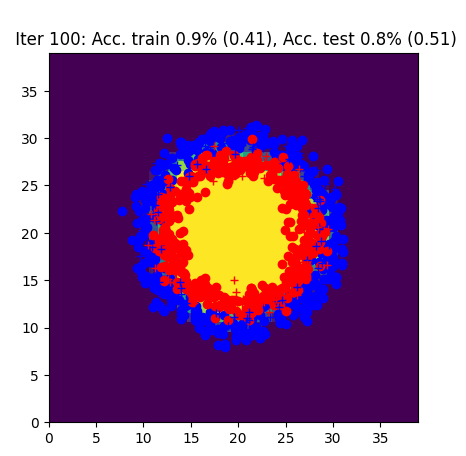

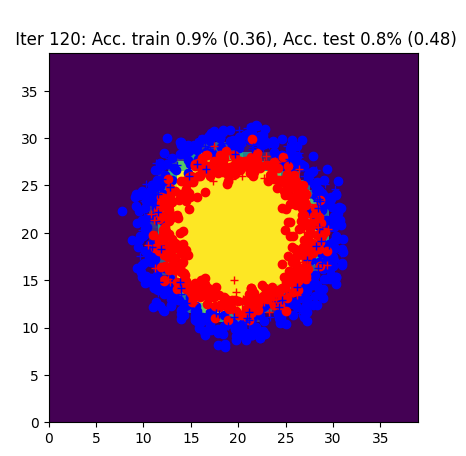

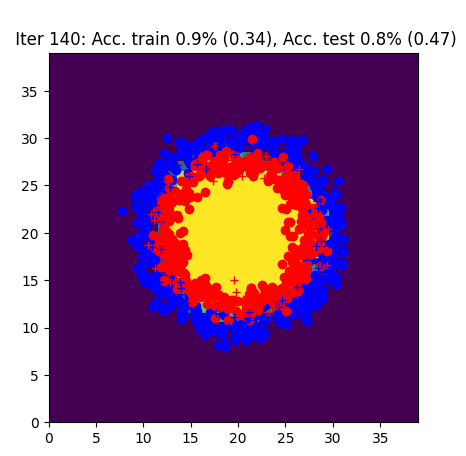

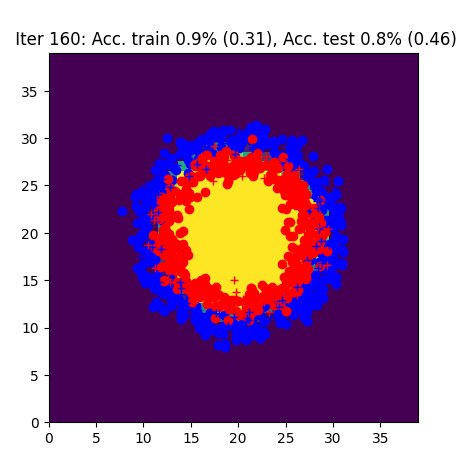

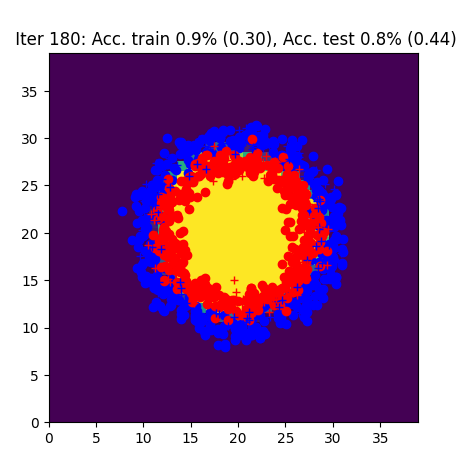

In [13]:
#initialisation des params
eta = 0.03
params = init_params(nx, nh, ny)

# epoch
curves = [[], [], [], [], [], []]
for iteration in range(200):

    # permutations
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #initialisation loss et acc par bacth
    Loss=[]
    Acc=[]

    for j in range(N // Nbatch):
        
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        #####################
        ## Votre code ici  ##
        #####################
        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant les fonctions forward, loss_accuracy, backward, sgd
        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        sgd(params, grads, eta)
        Loss.append(loss)
        Acc.append(acc)
    
    # accummulation de la loss et des accuracy par batch  
    LBatch = sum(Loss)/len(Loss)
    accBatch = sum(Acc)/len(Acc)
    
    # ou bien calculer sur la dataset d'entrainement entière
    Yhat_train, _ = forward(params, data.Xtrain)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)

    Yhat_test, _ = forward(params, data.Xtest)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    
    if iteration % 20 == 0 :
        title = f'\n Iter {iteration}: Acc. train {acctrain:.1f}% ({Ltrain:.2f}), Acc. test {acctest:.1f}% ({Ltest:.2f})'
        Ygrid, _ = forward(params, data.Xgrid)
        plot_data_with_grid(data,Ygrid, title)

    curves[0].append(accBatch)
    curves[1].append(acctrain)
    curves[2].append(acctest)

    curves[3].append(LBatch)
    curves[4].append(Ltrain)
    curves[5].append(Ltest)

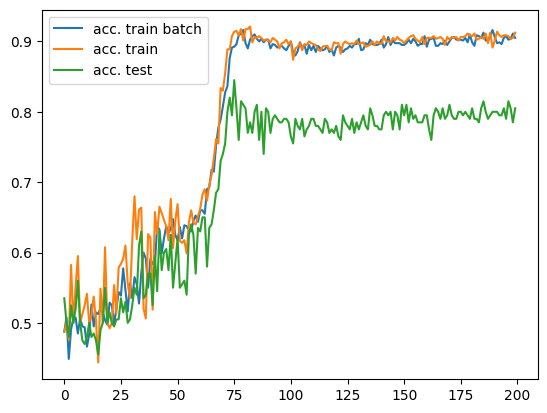

In [14]:
fig = plt.figure()
plt.plot(curves[0], label="acc. train batch")
plt.plot(curves[1], label="acc. train")
plt.plot(curves[2], label="acc. test")
plt.legend()
plt.show()

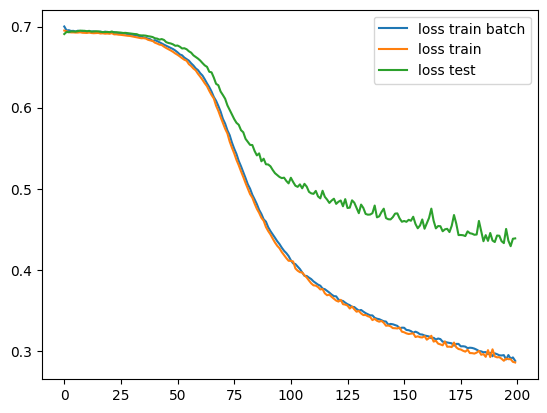

In [15]:
fig = plt.figure()
plt.plot(curves[3], label="loss train batch")
plt.plot(curves[4], label="loss train")
plt.plot(curves[5], label="loss test")

plt.legend()
plt.show()